In [1]:
import pandas as pd
import os
from matplotlib import rcParams
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 

import tensorflow.keras.backend as K
from keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
from tensorflow.python.framework.ops import disable_eager_execution
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity
disable_eager_execution()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
dataframe = pd.read_csv("/kaggle/input/data/Data_Entry_2017.csv")

In [3]:
dataframe.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [4]:
#Enumerating all column names
columns = ["Image"]
for i in dataframe["Finding Labels"].values:
    for j in i.split("|"):
        if j not in columns:
            columns.append(j)
labels = columns.copy()
labels.remove("Image")
labels.remove("No Finding")
columns.remove("No Finding")

In [5]:
#Taking the first 90000 images from the master table as the train dataset
trainset = pd.DataFrame(columns = columns)
for i in range(90000):
    col = [0]*len(columns)
    col[0] = dataframe["Image Index"][i]
    count = 1
    for j in columns[1:]:
        if(j in dataframe["Finding Labels"][i]):
            col[count] = 1
        count+=1
    trainset.loc[len(trainset)] = col

In [6]:
#Taking the next 10000 images from the master table as the validation dataset
valset = pd.DataFrame(columns = columns)
for i in range(90000, 100000):
    col = [0]*len(columns)
    col[0] = dataframe["Image Index"][i]
    count = 1
    for j in columns[1:]:
        if(j in dataframe["Finding Labels"][i]):
            col[count] = 1
        count+=1
    valset.loc[len(valset)] = col

In [7]:
#Taking the next 12000 images from the master table as the test dataset
testset = pd.DataFrame(columns = columns)
for i in range(100000, 112000):
    col = [0]*len(columns)
    col[0] = dataframe["Image Index"][i]
    count = 1
    for j in columns[1:]:
        if(j in dataframe["Finding Labels"][i]):
            col[count] = 1
        count+=1
    testset.loc[len(testset)] = col

In [8]:
testset1 = pd.DataFrame(columns = columns)
for i in range(50000, 50500):
    col = [0]*len(columns)
    col[0] = dataframe["Image Index"][i]
    count = 1
    for j in columns[1:]:
        if(j in dataframe["Finding Labels"][i]):
            col[count] = 1
        count+=1
    testset1.loc[len(testset1)] = col

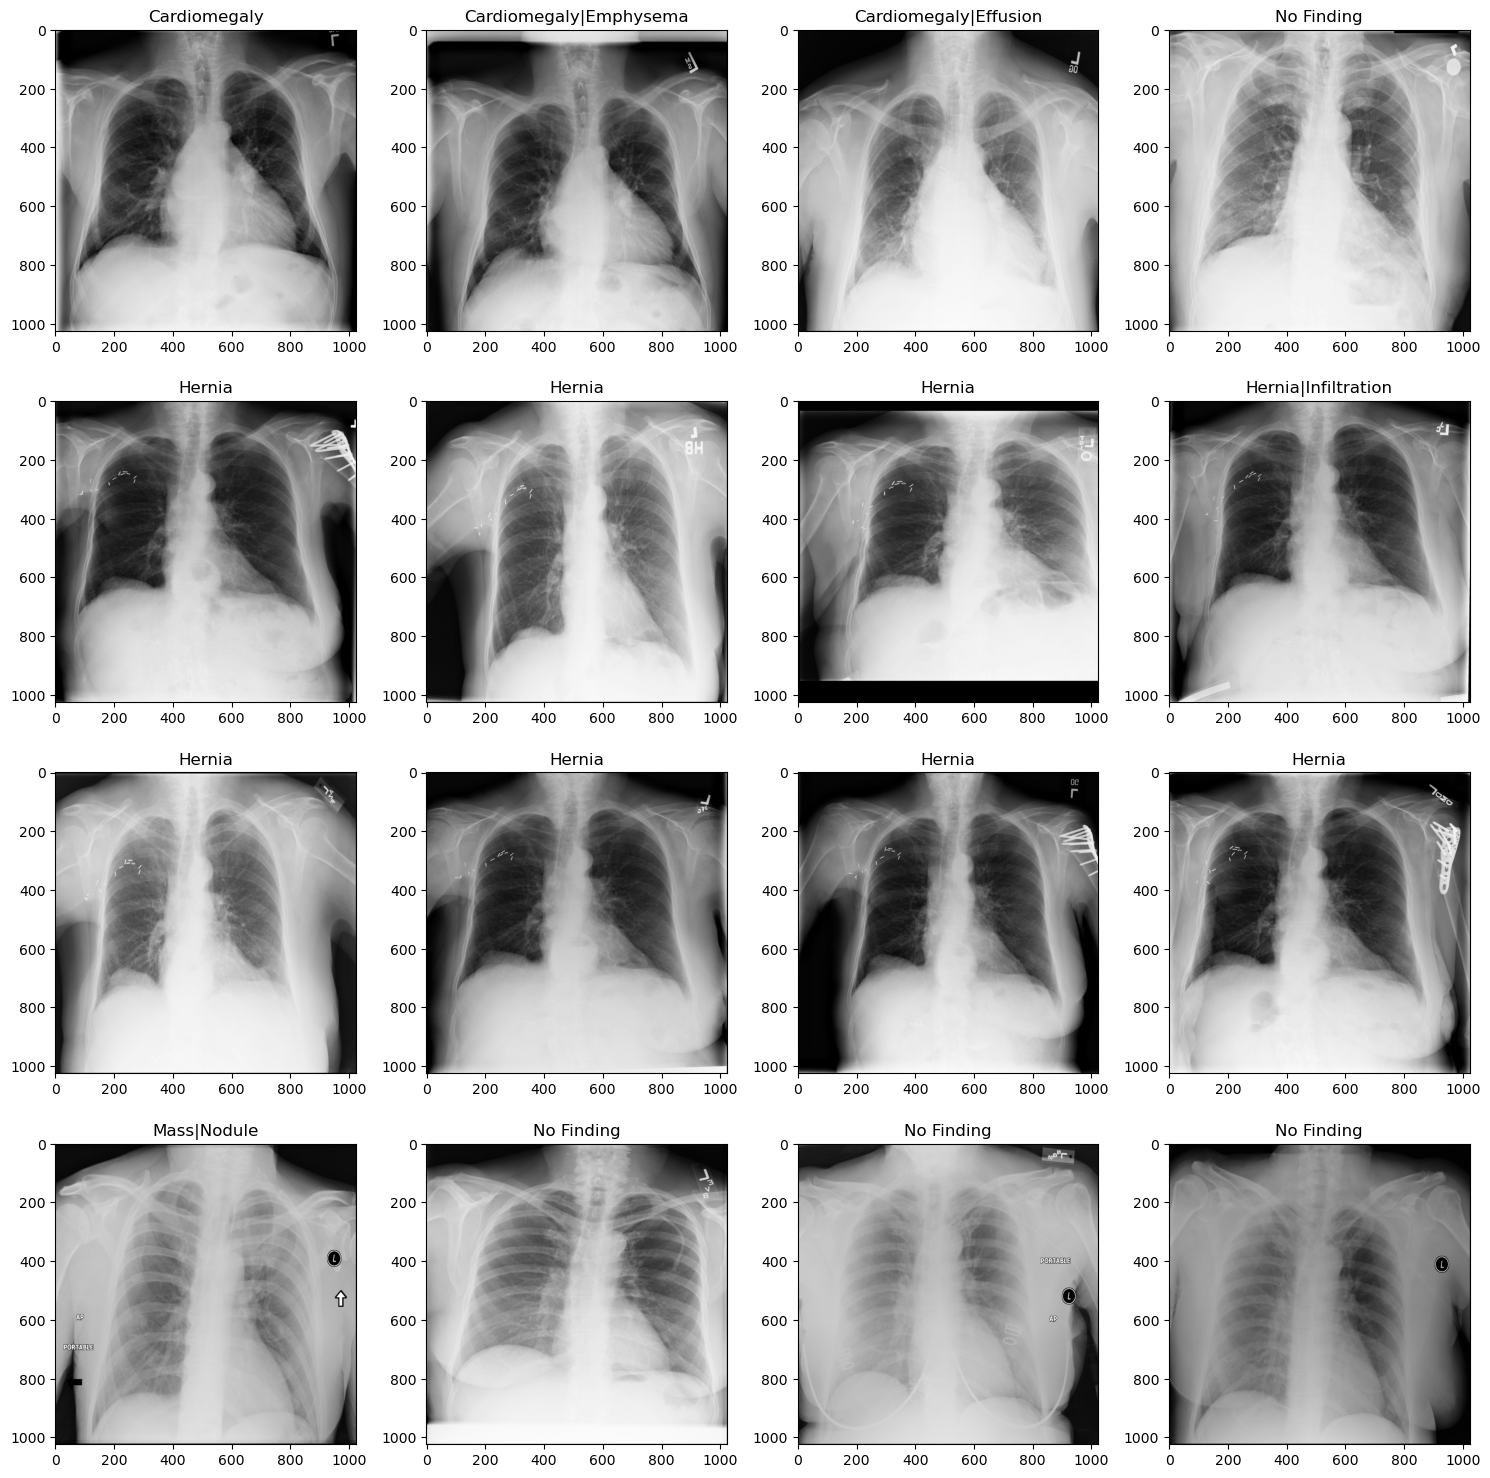

In [9]:
img_dir = "/kaggle/input/nih-chest/images/images"
plt.figure(figsize = (15,15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(plt.imread(os.path.join(img_dir, trainset["Image"][i])), cmap = "gray")
    plt.title(dataframe[dataframe["Image Index"] == trainset["Image"][i]].values[0][1])
plt.tight_layout()

In [10]:
trainset

,Image,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00000001_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,00022363_000.png,0,0,0,0,1,0,1,0,0,0,0,0,0,0
89996,00022364_000.png,0,0,0,0,0,1,0,0,0,0,0,0,0,0
89997,00022364_001.png,0,0,0,0,1,0,0,0,0,0,0,0,0,0
89998,00022364_002.png,0,0,0,0,1,0,0,0,0,0,0,0,0,0



#  Checking for Patient Overlap

In [11]:
def isOverlap(s1, s2):
    total = set(s1).intersection(set(s2))
    return [len(total), total]

In [12]:
def overlapcheck(trainset, valset, testset):
    patid_train = []
    patid_val = []
    patid_test = []
    for name in trainset['Image'].values:
        patid_train.append(int(name.split("_")[0]))

    for name in valset['Image'].values:
        patid_val.append(int(name.split("_")[0]))

    for name in testset['Image'].values:
        patid_test.append(int(name.split("_")[0]))
    trte = isOverlap(patid_train, patid_test)
    teva = isOverlap(patid_test, patid_val)
    trva = isOverlap(patid_train, patid_val)
    print("Patient Overlap - Train and Test: ", trte[0])
    print("Patient Overlap - Test and Validation: ", teva[0])
    print("Patient Overlap - Train and Validation: ", trva[0])
    return trte, teva, trva


In [13]:
trte, teva, trva = overlapcheck(trainset, valset, testset)

Patient Overlap - Train and Test:  0
Patient Overlap - Test and Validation:  1
Patient Overlap - Train and Validation:  1


,Image,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
46498,00011884_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0


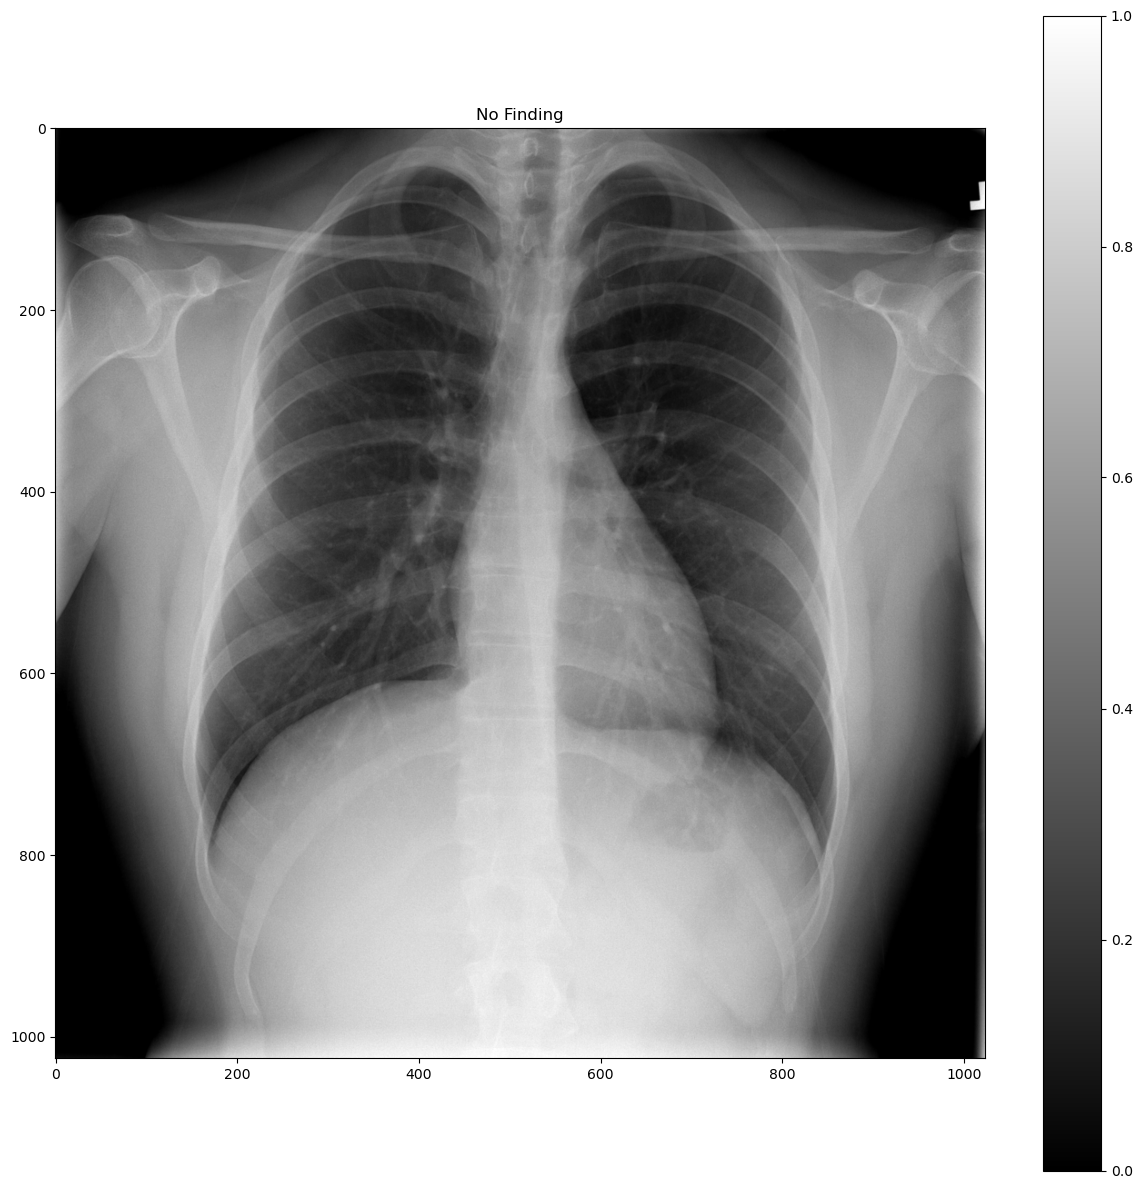

In [14]:
num = np.random.randint(trainset.shape[0])
sample = plt.imread(os.path.join(img_dir,trainset.iloc[[num]]["Image"].values[0]))
plt.figure(figsize=(15, 15))
plt.title(dataframe[dataframe["Image Index"] == trainset.iloc[[num]]["Image"].values[0]].values[0][1])
plt.imshow(sample, cmap = 'gray')
plt.colorbar()
trainset.iloc[[num]]


In [15]:
num

46498

In [16]:
print("Maximum Pixel Value: ", sample.max())
print("Minimum Pixel Value: ", sample.min())
print(f"Image dimension: {sample.shape[0]} x {sample.shape[1]} ")

Maximum Pixel Value:  1.0
Minimum Pixel Value:  0.0
Image dimension: 1024 x 1024 


Mean - Pixel Value:  0.4490703
Std Deviation Pixel Value:  0.259477


<Axes: xlabel='Pixel Values', ylabel='Count'>

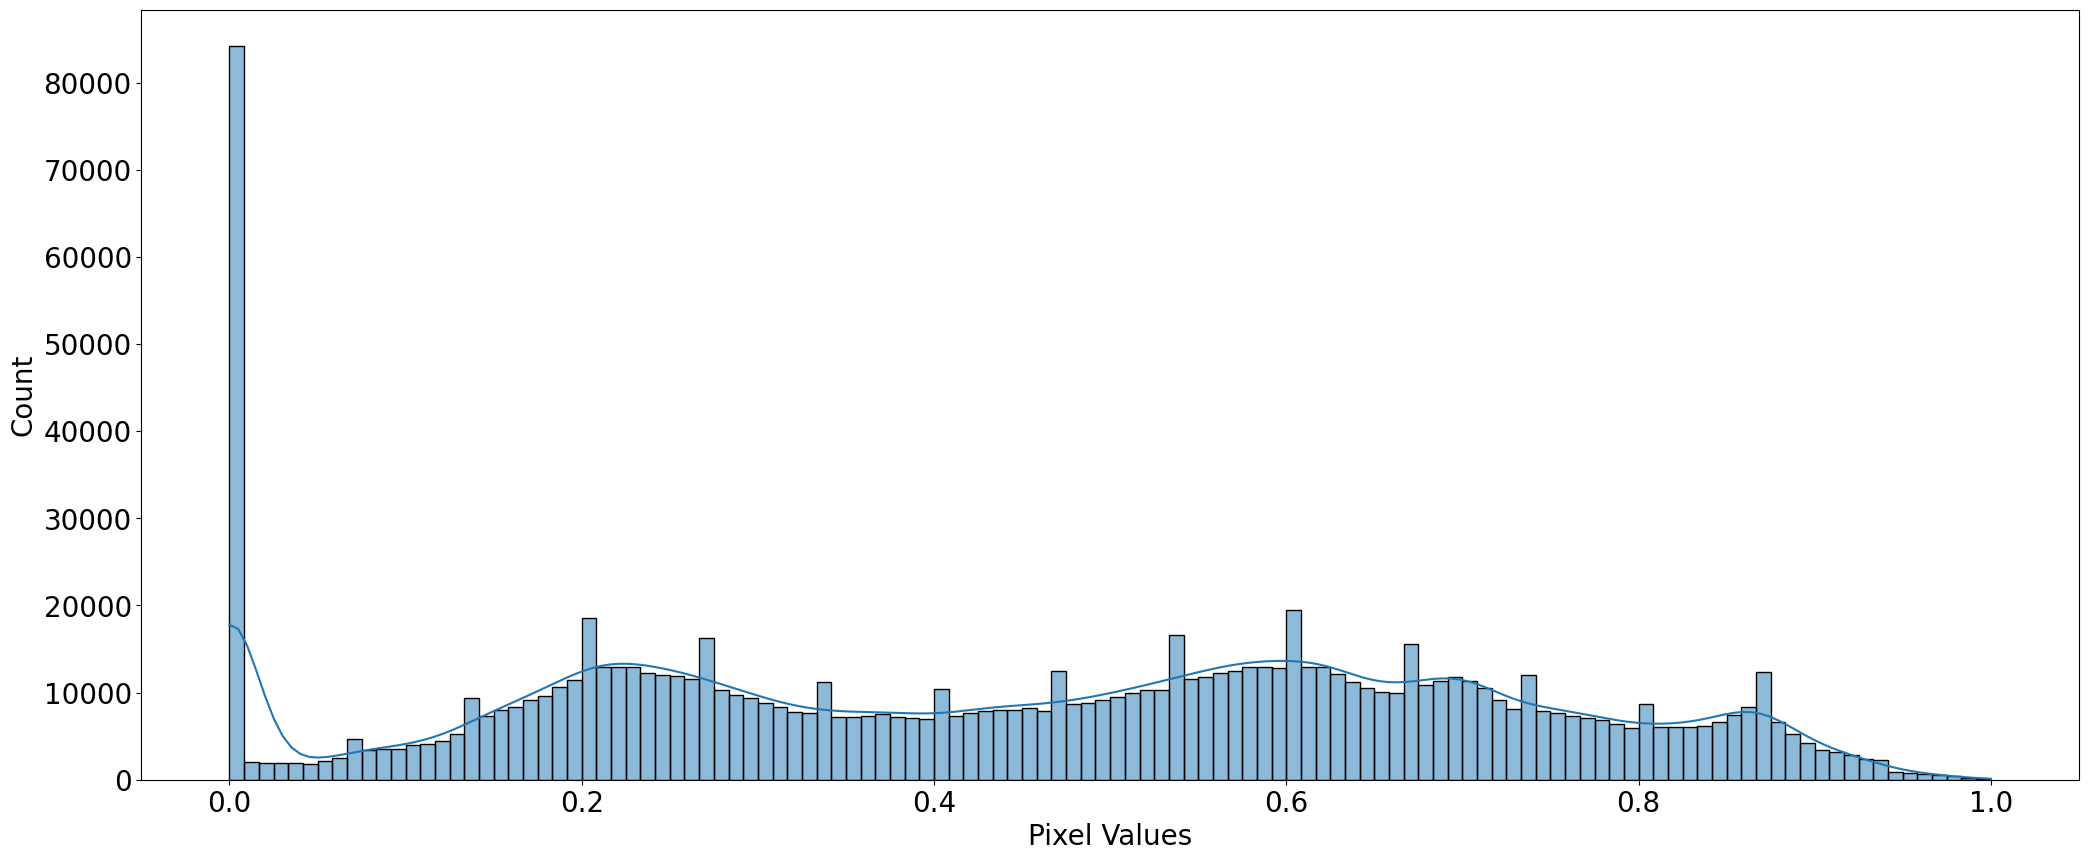

In [17]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(25, 10))
plt.xlabel("Pixel Values") 
print("Mean - Pixel Value: ", sample.mean())
print("Std Deviation Pixel Value: ", sample.std())
sns.histplot(sample.ravel(), ax = ax, kde = True)

In [18]:

from keras.preprocessing.image import ImageDataGenerator
traingen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization= True)
traingenerator = traingen.flow_from_dataframe(
        dataframe=trainset,
        directory="/kaggle/input/nih-chest/images/images",
        x_col="Image",
        y_col= labels,
        class_mode="raw",
        batch_size= 1,
        shuffle=True,
        target_size=(512,512)
)

Found 90000 validated image filenames.


In [19]:
imagegen = ImageDataGenerator().flow_from_dataframe(dataframe = trainset, directory = "/kaggle/input/nih-chest/images/images", x_col = "Image", y_col = labels, class_mode = "raw", batch_size= 1, shuffle=True, target_size=(512,512))
train_sample = imagegen.next()[0]
imagegen1 = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization= True)
imagegen1.fit(train_sample)

valgenerator = imagegen1.flow_from_dataframe(dataframe = valset, directory = "/kaggle/input/nih-chest/images/images", x_col = "Image", y_col = labels, class_mode = "raw", batch_size= 1, shuffle=True, target_size=(512,512))
testgenerator = imagegen1.flow_from_dataframe(dataframe = testset, directory = "/kaggle/input/nih-chest/images/images", x_col = "Image", y_col = labels, class_mode = "raw", batch_size= 1, shuffle=True, target_size=(512,512))

Found 90000 validated image filenames.
Found 10000 validated image filenames.
Found 12000 validated image filenames.


In [20]:
testgenerator1 = imagegen1.flow_from_dataframe(dataframe = testset1, directory = "/kaggle/input/nih-chest/images/images", x_col = "Image", y_col = labels, class_mode = "raw", batch_size= 1, shuffle=True, target_size=(512,512))

Found 500 validated image filenames.


In [21]:
item, value = traingenerator.__getitem__(num)

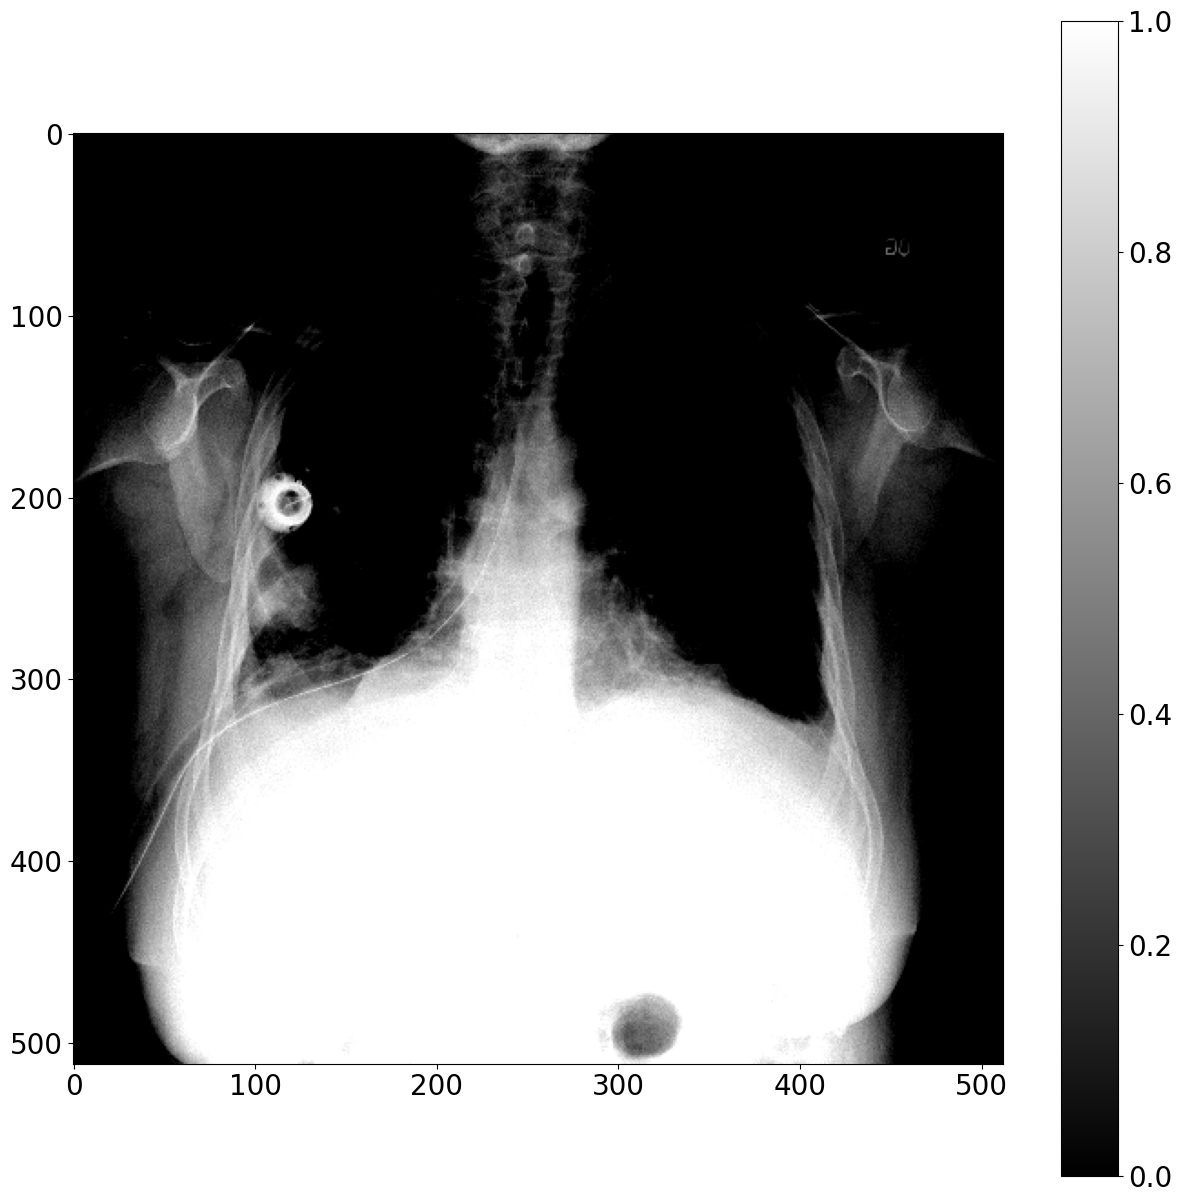

In [22]:
plt.figure(figsize=(15, 15))
plt.imshow(item[0], cmap = 'gray')
plt.colorbar()

Mean of Pixel Values - Standardized:  -1.8750627e-07
Standard Deviation of Pixel Values - Standardized:  1.0
Mean of Pixel Values - Sample:  0.4490703
Standard Deviation of Pixel Values - Sample:  0.259477


<Axes: xlabel='Pixel Values', ylabel='Count'>

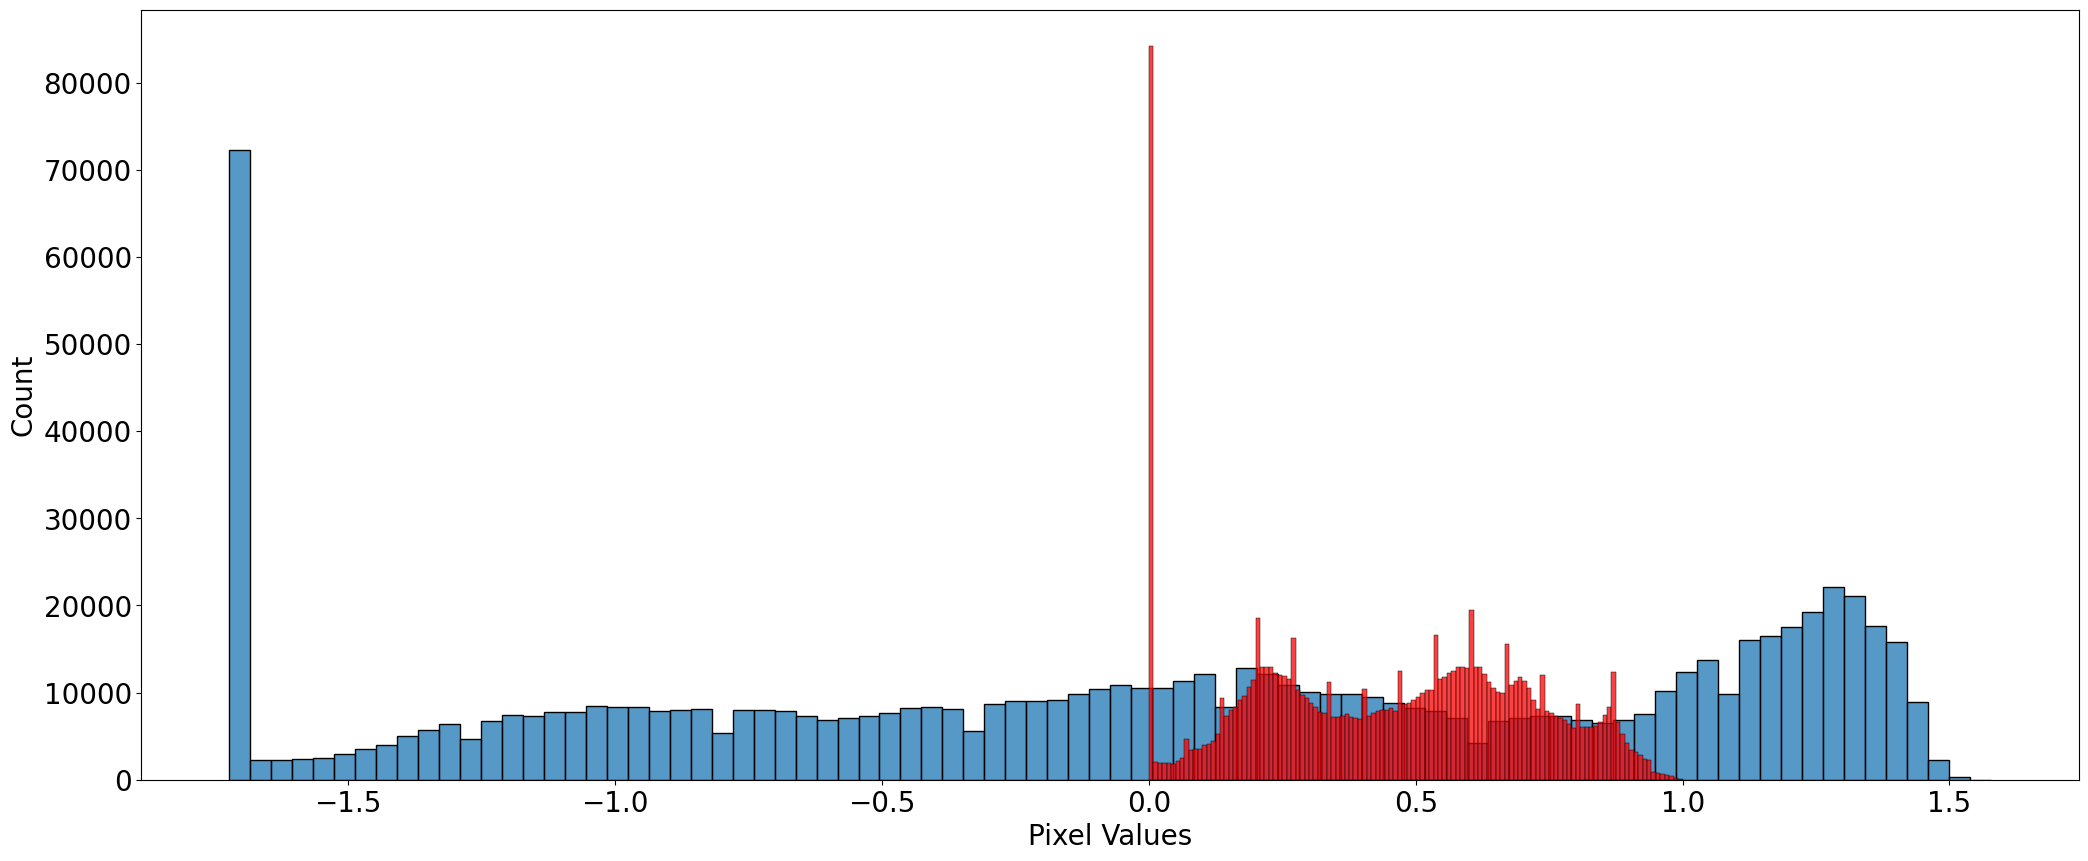

In [23]:

fig, ax = plt.subplots(figsize=(25, 10))
plt.xlabel("Pixel Values")
print("Mean of Pixel Values - Standardized: ", item[0].mean())
print("Standard Deviation of Pixel Values - Standardized: ", item[0].std())
print("Mean of Pixel Values - Sample: ", sample.mean())
print("Standard Deviation of Pixel Values - Sample: ", sample.std())
sns.histplot(item[0].ravel(), ax = ax, kde = False)
sns.histplot(sample.ravel(), ax = ax, kde = False, color = "red")

In [24]:
plt.rcParams.update({'font.size': 12})

In [25]:

positive_freqs = np.mean(traingenerator.labels, axis = 0)
negative_freqs = 1 - positive_freqs

In [26]:

data = {
    'Class': labels,
    'Positive': positive_freqs,
    'Negative':negative_freqs
}

In [27]:
negative_freqs

array([0.97457778, 0.97801111, 0.88244444, 0.99781111, 0.82805556,
       0.94702222, 0.9438    , 0.895     , 0.9559    , 0.9696    ,
       0.98674444, 0.98301111, 0.97845556, 0.95702222])

In [28]:

positive_freqs

array([0.02542222, 0.02198889, 0.11755556, 0.00218889, 0.17194444,
       0.05297778, 0.0562    , 0.105     , 0.0441    , 0.0304    ,
       0.01325556, 0.01698889, 0.02154444, 0.04297778])

<Figure size 2000x1500 with 0 Axes>

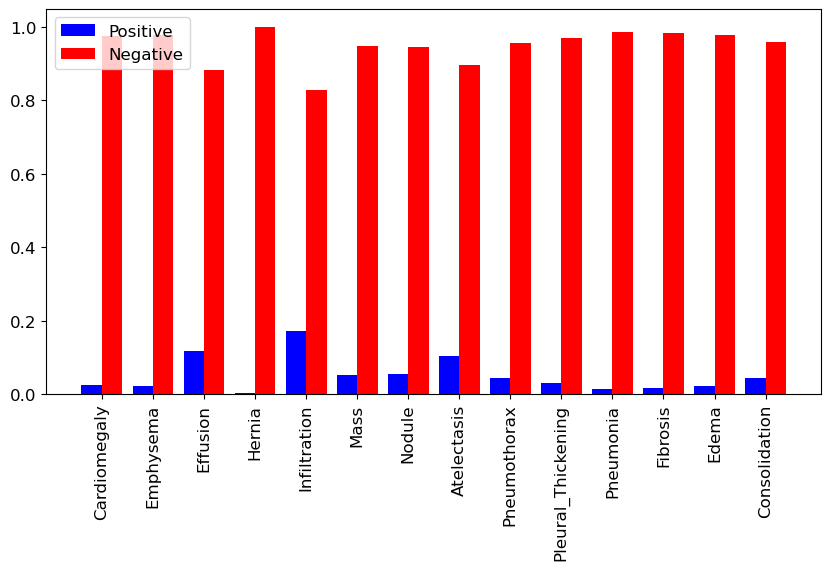

<Figure size 2000x1500 with 0 Axes>

In [29]:
X_axis = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(X_axis-0.2, data['Positive'], width=0.4, color='b', label = "Positive")
ax.bar(X_axis+0.2, data['Negative'], width=0.4, color='r', label = 'Negative')
plt.xticks(X_axis, labels, rotation = 90)
plt.legend()
plt.figure(figsize=(20,15))

In [30]:
data = {
    'Class': labels,
    'Positive': positive_freqs*negative_freqs,
    'Negative':negative_freqs*positive_freqs
}

<Figure size 2000x1500 with 0 Axes>

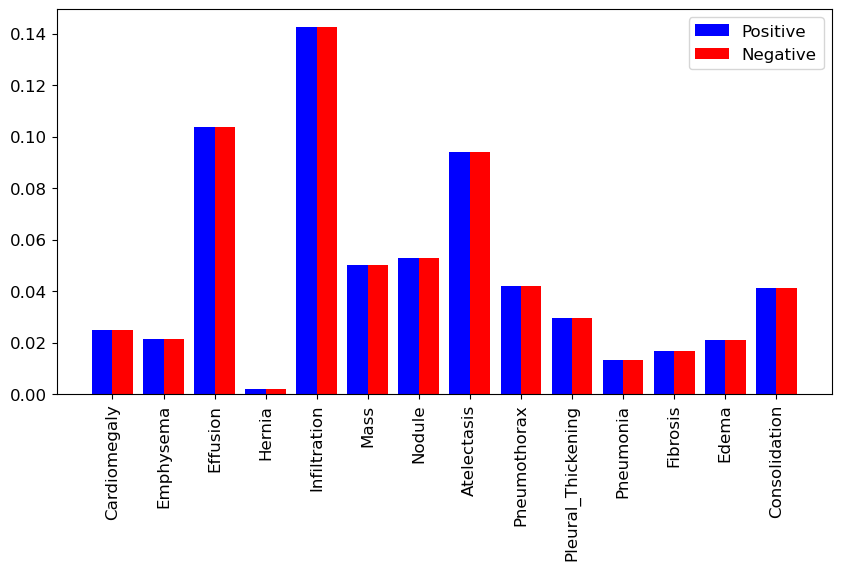

<Figure size 2000x1500 with 0 Axes>

In [31]:
X_axis = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(X_axis-0.2, data['Positive'], width=0.4, color='b', label = "Positive")
ax.bar(X_axis+0.2, data['Negative'], width=0.4, color='r', label = 'Negative')
plt.xticks(X_axis, labels, rotation = 90)
plt.legend()
plt.figure(figsize=(20,15))

In [32]:
def calcloss(positivewt, negativewt, al=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(positivewt)):
            loss += -((positivewt[i] * K.transpose(y_true)[i] * K.log(K.transpose(y_pred)[i] + al))+(negativewt[i]*(1 - K.transpose(y_true)[i])*K.log(1 - K.transpose(y_pred)[i] + al)))
        return K.mean(loss)
    return weighted_loss

In [33]:
model = DenseNet121(weights='/kaggle/input/densenet/densenet.hdf5', include_top=False)
model = Model(inputs=model.input, outputs=Dense(len(labels), activation="sigmoid")(GlobalAveragePooling2D()(model.output)))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                           

In [ ]:
model.compile(optimizer='adam', loss=calcloss(negative_freqs, positive_freqs))
fitter = model.fit(traingenerator, validation_data=valgenerator, steps_per_epoch = 1000, epochs = 50)

Epoch 1/50
 21/100 [=====>........................] - ETA: 27s - batch: 10.0000 - size: 1.0000 - loss: 1.0351

In [ ]:
‘

In [37]:
model.save_weights("cxr_mahima.h5")

In [38]:
plt.plot(fitter.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

NameError: name 'fitter' is not defined

In [ ]:
predicted_vals = model.predict(testgenerator, steps = len(testgenerator))
predicted_vals1 = model.predict(testgenerator1, steps = len(testgenerator1))

In [ ]:

auc_roc_vals = []
for i in range(len(labels)):
    try:
        gt = np.array(testgenerator.labels[:, i])
        pred = predicted_vals[:,i]
        gt = gt.astype('int64')
        gt = gt.reshape(-1, 1)
        auc_roc = roc_auc_score(gt, pred)
        print(auc_roc)
        auc_roc_vals.append(auc_roc)
        fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
        plt.figure(1, figsize=(10, 10))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_rf, tpr_rf,
                 label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
    except ValueError:
        pass
plt.show()

In [ ]:
auc_roc_vals = []
for i in range(len(labels)):
    try:
        gt = np.array(testgenerator1.labels[:, i])
        pred = predicted_vals1[:,i]
        gt = gt.astype('int64')
        gt = gt.reshape(-1, 1)
        auc_roc = roc_auc_score(gt, pred)
        print(auc_roc)
        auc_roc_vals.append(auc_roc)
        fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
        plt.figure(1, figsize=(10, 10))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_rf, tpr_rf,
                 label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
    except ValueError:
        pass
plt.show()

In [ ]:
labels2show = np.take(labels, np.argsort(auc_roc_vals)[::-1])[:4]
labels2show

In [ ]:
def get_mean_std_per_batch(image_path, df, H=400, W=400):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

def load_image(img, image_dir, df, preprocess=True, H=400, W=400):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


def grad_cam(input_model, image, cls, layer_name, H=400, W=400):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1

In [ ]:
compute_gradcam(model, '00000001_001.png', "images/", trainset, labels, labels2show)

In [ ]:
compute_gradcam(model, '00000013_024.png', "images/", trainset, labels, labels2show)